# Multivariate LSTM RNN - Indoor Temperature Prediction 

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

2024-04-01 21:32:03.664928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 21:32:03.666124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 21:32:03.684471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 21:32:03.684490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 21:32:03.685009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### Importing Data

In [2]:
df = pd.read_csv("/home/fraia/Arduino/Predictive Model/data_cl/home_data_cl_21_03.csv")

In [3]:
df

,Unnamed: 0,id,timestamp,sense_hum,sense_temp,open_hum,open_temp,pressure,water_temp
0,3,4,2024-02-21 09:24:31,40.8,21.9,70.0,6.74,1027.0,30.0
1,4,5,2024-02-21 09:29:39,41.5,21.7,71.0,6.81,1028.0,30.0
2,5,6,2024-02-21 09:34:45,41.8,21.6,68.0,7.30,1028.0,30.0
3,6,6,2024-02-21 09:34:45,41.8,21.6,68.0,7.30,1028.0,29.0
4,7,7,2024-02-21 09:39:52,42.0,21.6,68.0,7.30,1028.0,29.0
...,...,...,...,...,...,...,...,...,...
3888,3891,3448,2024-03-05 07:18:29,38.0,22.1,67.0,5.56,1022.0,30.0
3889,3892,3449,2024-03-05 07:23:35,38.1,22.1,67.0,5.56,1022.0,30.0
3890,3893,3450,2024-03-05 07:28:42,38.0,22.0,67.0,5.56,1022.0,30.0
3891,3894,3451,2024-03-05 07:33:48,38.0,22.1,66.0,5.58,1022.0,30.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3893 non-null   int64  
 1   id          3893 non-null   int64  
 2   timestamp   3893 non-null   object 
 3   sense_hum   3893 non-null   float64
 4   sense_temp  3893 non-null   float64
 5   open_hum    3893 non-null   float64
 6   open_temp   3893 non-null   float64
 7   pressure    3893 non-null   float64
 8   water_temp  3893 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 273.9+ KB


In [5]:
#rearange column order so that sense_temp (target variable) is at the beginning of the other relevant features
df = df[["id", "timestamp", "sense_temp", "sense_hum", "open_hum", "open_temp", "pressure", "water_temp"]]

### Data Exploration

In [6]:
#convert to timestamp to DateTime object 
df["timestamp"] = pd.to_datetime(df["timestamp"])

/tmp/ipykernel_19839/2525917120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


In [7]:
df.isna().sum()

id            0
timestamp     0
sense_temp    0
sense_hum     0
open_hum      0
open_temp     0
pressure      0
water_temp    0
dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

/tmp/ipykernel_19839/3006716147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [9]:
df.duplicated().sum()

0

In [10]:
df_cl = df

# Undersample df -> each interval of 30min 
df_cl = df_cl[::6]

# Reorder columns
df_cl = df_cl[['timestamp','sense_temp','water_temp','sense_hum', 'open_temp', 'open_hum', 'pressure']]

#set timestamp as index
df_cl = df_cl.set_index('timestamp')

df_cl

,sense_temp,water_temp,sense_hum,open_temp,open_hum,pressure
timestamp,,,,,,
2024-02-21 09:24:31,21.9,30.0,40.8,6.74,70.0,1027.0
2024-02-21 09:50:24,21.6,28.0,41.6,7.30,68.0,1028.0
2024-02-21 10:21:54,21.7,27.0,41.5,8.89,65.0,1028.0
2024-02-21 10:52:40,21.7,26.0,41.4,9.80,64.0,1028.0
2024-02-21 11:18:14,21.8,25.0,41.4,10.47,62.0,1027.0
...,...,...,...,...,...,...
2024-03-05 05:10:48,21.9,30.0,38.5,5.91,70.0,1021.0
2024-03-05 05:41:27,22.0,30.0,38.4,5.97,70.0,1021.0
2024-03-05 06:12:06,22.1,30.5,38.1,6.04,70.0,1021.0


In [11]:
# Rolling window - smoothing data
df_rolled = df_cl.rolling(window = 20).mean().dropna()

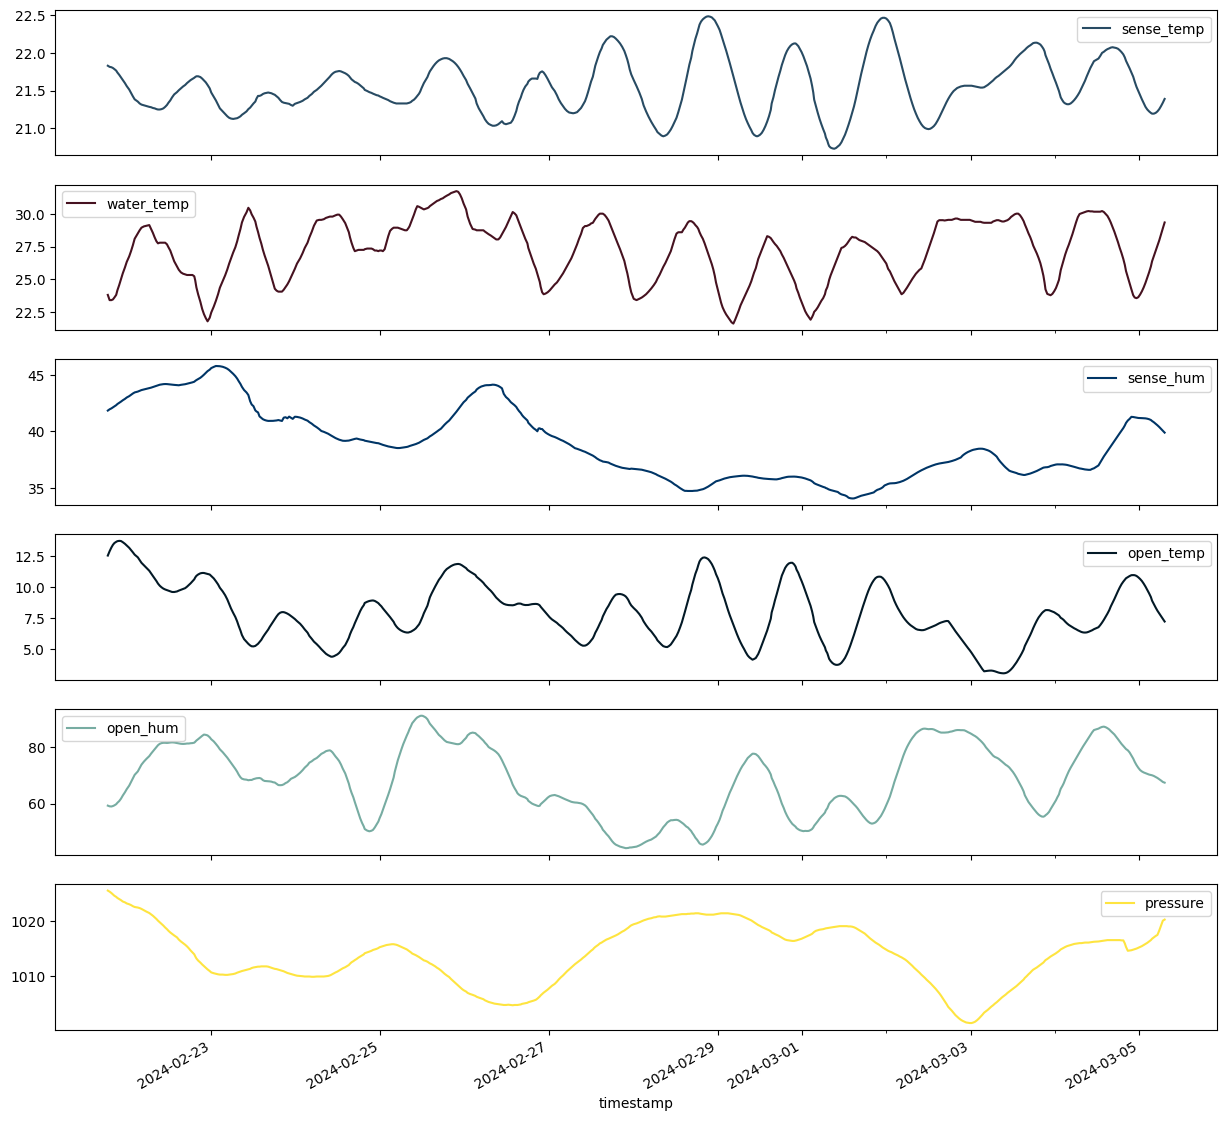

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Custom color palette
colors = ["#284b63", "#461220", "#fb8500", "#003566",
           "#8ecae6", "#031926", "#468189", "#77aca2",
           "#fee440"]
# Create a custom color map
cmap = ListedColormap(colors)

# Plot using the custom color map
df_rolled.plot(subplots=True, figsize=(15, 15), colormap=cmap)

plt.show()

### Feature Extraction

In [13]:
# Adding new varaibles , namely an interaction between water_temp and sense_temp and a log transformation of water_temp
df_rolled["water_temp_log"] = np.log(df_rolled["water_temp"])
df_rolled["st_wt"] = df_rolled["sense_temp"] * df_rolled["water_temp"]

In [14]:
# Remove irrelevant features apply differencing for trend removal
df_rolled_rel = df_rolled.drop(columns=["pressure"]) 
df_diff = df_rolled_rel.diff().dropna()

In [15]:
from feature_selection import check_stationarity, scaling, feat_extraction, feat_selection

df_stationar = check_stationarity(df_diff)
df_scaled, scaler = scaling(df_stationar)
X, y= feat_extraction(df_scaled, target_col="sense_temp")
df_selection = feat_selection(X, y)

#set index again to timestamp -> it was reset for the feature extraction process
df_scaled = df_scaled.set_index("timestamp")

sense_temp
ADF Statistic: -9.266290
p-value: 0.000000


water_temp
ADF Statistic: -10.115496
p-value: 0.000000


sense_hum
ADF Statistic: -6.199781
p-value: 0.000000


open_temp
ADF Statistic: -7.848404
p-value: 0.000000


open_hum
ADF Statistic: -7.265994
p-value: 0.000000


water_temp_log
ADF Statistic: -9.799469
p-value: 0.000000


st_wt
ADF Statistic: -10.055111
p-value: 0.000000




Feature Extraction: 100%|██████████| 60/60 [00:09<00:00,  6.59it/s]


### Feature Selection

In [16]:
"""
# set up our regressor. Today we shall be using the random forest
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

# perform a scikit-learn Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 15
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X, y)"""

'\n# set up our regressor. Today we shall be using the random forest\nfrom sklearn.ensemble import RandomForestRegressor\nregressor = RandomForestRegressor(n_estimators=100, max_depth=10)\n\n# perform a scikit-learn Recursive Feature Elimination (RFE)\nfrom sklearn.feature_selection import RFE\n\n# here we want only one final feature, we do this to produce a ranking\nn_features_to_select = 15\nrfe = RFE(regressor, n_features_to_select=n_features_to_select)\nrfe.fit(X, y)'

In [17]:
"""
from operator import itemgetter
features = X.columns.to_list()
for x_rf, y_rf in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x_rf, y_rf)
"""

'\nfrom operator import itemgetter\nfeatures = X.columns.to_list()\nfor x_rf, y_rf in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):\n    print(x_rf, y_rf)\n'

In [18]:
"""
from operator import itemgetter
selected = []
features = X.columns.to_list()
top_15_features = [x_rf[1] for x_rf in sorted(zip(rfe.ranking_ , features), key=itemgetter(0))]
print(top_15_features)"""

'\nfrom operator import itemgetter\nselected = []\nfeatures = X.columns.to_list()\ntop_15_features = [x_rf[1] for x_rf in sorted(zip(rfe.ranking_ , features), key=itemgetter(0))]\nprint(top_15_features)'

In [19]:
"""
from operator import itemgetter

selected = []
features = X.columns.to_list()
top_features = [x_rf[1] for x_rf in sorted(zip(rfe.ranking_ , features), key=itemgetter(0))]

for feature in top_features:
    prefix = "_".join(feature.split("_")[:2])  # Extracting the first two strings
    if not any(prefix in s for s in selected):  # Checking if prefix already exists in selected
        selected.append(feature)

print(selected)
"""

'\nfrom operator import itemgetter\n\nselected = []\nfeatures = X.columns.to_list()\ntop_features = [x_rf[1] for x_rf in sorted(zip(rfe.ranking_ , features), key=itemgetter(0))]\n\nfor feature in top_features:\n    prefix = "_".join(feature.split("_")[:2])  # Extracting the first two strings\n    if not any(prefix in s for s in selected):  # Checking if prefix already exists in selected\n        selected.append(feature)\n\nprint(selected)\n'

In [20]:
"""top_df = pd.concat([y, X["open_temp__sum_values"],X['sense_hum__quantile__q_0.8'], df_scaled["water_temp_log"], df_scaled["st_wt"], df_scaled["water_temp"]], axis=1)"""

'top_df = pd.concat([y, X["open_temp__sum_values"],X[\'sense_hum__quantile__q_0.8\'], df_scaled["water_temp_log"], df_scaled["st_wt"], df_scaled["water_temp"]], axis=1)'

In [21]:
"""
correlation = top_df.corr()
sns.heatmap(correlation, annot=True, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True))
"""

"\ncorrelation = top_df.corr()\nsns.heatmap(correlation, annot=True, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True))\n"

In [22]:
"""
#variables causing multicollinearity will be dropped
correlated = ["st_wt__root_mean_square"]
top_df = top_df.drop(columns=correlated)

"""

'\n#variables causing multicollinearity will be dropped\ncorrelated = ["st_wt__root_mean_square"]\ntop_df = top_df.drop(columns=correlated)\n\n'

### Granger Causality Test

In [23]:
"""
from statsmodels.tsa.stattools import coint
t_statistics, p_val, critical_p_val = coint(top_df["sense_temp"], top_df["water_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")
"""

'\nfrom statsmodels.tsa.stattools import coint\nt_statistics, p_val, critical_p_val = coint(top_df["sense_temp"], top_df["water_temp"])\nprint(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")\n'

In [24]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
water_col = ["sense_temp"]
df_temp_wat = pd.concat([df_scaled[water_col], X["water_temp__abs_energy"]], axis= 1)
grangercausalitytests(df_temp_wat, 10, verbose = True)"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nwater_col = ["sense_temp"]\ndf_temp_wat = pd.concat([df_scaled[water_col], X["water_temp__abs_energy"]], axis= 1)\ngrangercausalitytests(df_temp_wat, 10, verbose = True)'

In [25]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
water_col = ["sense_temp", "water_temp_log"]
df_temp_wat = df_scaled[water_col]
grangercausalitytests(df_temp_wat, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nwater_col = ["sense_temp", "water_temp_log"]\ndf_temp_wat = df_scaled[water_col]\ngrangercausalitytests(df_temp_wat, 10, verbose = True)\n'

In [26]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
ot_col = ["sense_temp", "open_temp__median"]
df_temp_ot = top_df[ot_col]
grangercausalitytests(df_temp_ot, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\not_col = ["sense_temp", "open_temp__median"]\ndf_temp_ot = top_df[ot_col]\ngrangercausalitytests(df_temp_ot, 10, verbose = True)\n'

In [27]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
st_wt_col = ["sense_temp", 'st_wt__absolute_maximum']
df_temp_st_wt = top_df[st_wt_col]
grangercausalitytests(df_temp_st_wt, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nst_wt_col = ["sense_temp", \'st_wt__absolute_maximum\']\ndf_temp_st_wt = top_df[st_wt_col]\ngrangercausalitytests(df_temp_st_wt, 10, verbose = True)\n'

In [28]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
hum_col = ["sense_temp", 'sense_hum__quantile__q_0.8']
df_temp_hum = top_df[hum_col]
grangercausalitytests(df_temp_hum, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nhum_col = ["sense_temp", \'sense_hum__quantile__q_0.8\']\ndf_temp_hum = top_df[hum_col]\ngrangercausalitytests(df_temp_hum, 10, verbose = True)\n'

In [29]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
wt_col = ["sense_temp", 'water_temp_log__abs_energy']
df_temp_wt = top_df[wt_col]
grangercausalitytests(df_temp_wt, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nwt_col = ["sense_temp", \'water_temp_log__abs_energy\']\ndf_temp_wt = top_df[wt_col]\ngrangercausalitytests(df_temp_wt, 10, verbose = True)\n'

In [30]:
"""
from statsmodels.tsa.stattools import grangercausalitytests
oh_col = ["sense_temp", 'open_hum__absolute_maximum']
df_temp_oh = top_df[oh_col]
grangercausalitytests(df_temp_oh, 10, verbose = True)
"""

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\noh_col = ["sense_temp", \'open_hum__absolute_maximum\']\ndf_temp_oh = top_df[oh_col]\ngrangercausalitytests(df_temp_oh, 10, verbose = True)\n'

### Df for Training

In [31]:
#According to granger causality test only open_temp, water_temp, sense_hum will be included
#final_col = ["open_temp__sum_values"]
final_col1 = ["st_wt", "sense_hum"]
final_col = ["open_temp__sum_values", 'sense_hum__quantile__q_0.8']
#final_col = ["st_wt", "open_temp", 'sense_hum']
final_df = pd.concat([y, df_scaled["st_wt"], X[final_col]], axis=1)
#final_df = pd.concat([y, df_scaled[final_col]], axis=1)


### Split into training and test data

In [32]:
split_index = int(final_df.shape[0] * 0.9)
df_train = final_df.iloc[:split_index]
df_test= final_df.iloc[split_index:]

print(df_train.shape)
print(df_test.shape)

(532, 4)
(60, 4)


In [33]:
#Create a timestamp dataset for future plots
train_set_timestamp = df_train.index
test_set_timestamp = df_test.index

In [34]:
#extract required features
columns = list(df_train.columns)
print(columns)

df_train = df_train[columns].astype(float)
df_test = df_test[columns].astype(float)

['sense_temp', 'st_wt', 'open_temp__sum_values', 'sense_hum__quantile__q_0.8']


In [35]:
df_train.shape

(532, 4)

### Prepare training & testing sets -> 3D shaped
Code inspired on Digital Sreeni

In [36]:
train_X = []
train_y = []

n_future = 1 #Number of hours (12 = 1 hr) we want to look into the future based on past measures
n_past = 5 #Number of past values we want to use to predict the future

for i in range(n_past, len(df_train) - n_future + 1):
    train_X.append(df_train.iloc[i - n_past:i, :])  # Select all columns using ':'
    train_y.append(df_train.iloc[i + n_future - 1:i + n_future, 0])

train_X, train_y = np.array(train_X), np.array(train_y)

print("train_x shape == {}".format(train_X.shape))
print("train_y shape == {}".format(train_y.shape))

train_x shape == (527, 5, 4)
train_y shape == (527, 1)


In [37]:
test_X = []
#test_y = []

n_future_test = 1 #Number of hours (12 = 1 hr) we want to look into the future based on past measures
n_past_test = 5 #Number of past values we want to use to predict the future

for i in range(n_past, len(df_test) - n_future + 1):
    test_X.append(df_test.iloc[i - n_past:i, :])  # Select all columns using ':'
    #test_y.append(df_test.iloc[i + n_future - 1:i + n_future, 0])

test_X = np.array(test_X)
#test_y = np.array(test_y)

print("test_x shape == {}".format(test_X.shape))
#print("test_y shape == {}".format(test_y.shape))

test_x shape == (55, 5, 4)


### Training the model
Code inspired on Digital Sreeni

In [38]:
model = Sequential()
model.add(LSTM(64, activation = "relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences= True)) #64 units, input_shape (see above), return_sequences True -> we want this LSTM to return a sequence that will be processed by the next LSTM 
model.add(LSTM(32, activation= "relu", return_sequences= False)) #return_sequence False -> not returning a sequence, it's returning a vector that goes into the Dense Layer
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-01 21:32:16.530880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 21:32:16.531092: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [39]:
#fit the model 
history = model.fit(train_X, train_y, epochs=20, batch_size=20, validation_split= 0.1, verbose=1)

Epoch 1/20
24/24 [==============================] - 1s 8ms/step - loss: 0.8409 - val_loss: 0.2158
Epoch 2/20
24/24 [==============================] - 0s 2ms/step - loss: 0.2280 - val_loss: 0.1068
Epoch 3/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1388 - val_loss: 0.0696
Epoch 4/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1476 - val_loss: 0.0633
Epoch 5/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1256 - val_loss: 0.0617
Epoch 6/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.0432
Epoch 7/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.0537
Epoch 8/20
24/24 [==============================] - 0s 2ms/step - loss: 0.0963 - val_loss: 0.0497
Epoch 9/20
24/24 [==============================] - 0s 2ms/step - loss: 0.0840 - val_loss: 0.0449
Epoch 10/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0473
Epoch 11/20
24/24 [

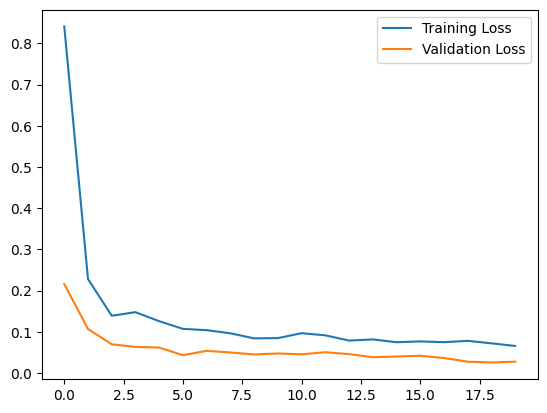

In [40]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()

### Forecasting
Code inspired on Digital Sreeni

In [41]:
periods = 1
forecast_period = pd.date_range(list(train_set_timestamp)[-1], periods=len(test_set_timestamp), freq="5min").tolist()
print(forecast_period)

[Timestamp('2024-03-04 01:09:13'), Timestamp('2024-03-04 01:14:13'), Timestamp('2024-03-04 01:19:13'), Timestamp('2024-03-04 01:24:13'), Timestamp('2024-03-04 01:29:13'), Timestamp('2024-03-04 01:34:13'), Timestamp('2024-03-04 01:39:13'), Timestamp('2024-03-04 01:44:13'), Timestamp('2024-03-04 01:49:13'), Timestamp('2024-03-04 01:54:13'), Timestamp('2024-03-04 01:59:13'), Timestamp('2024-03-04 02:04:13'), Timestamp('2024-03-04 02:09:13'), Timestamp('2024-03-04 02:14:13'), Timestamp('2024-03-04 02:19:13'), Timestamp('2024-03-04 02:24:13'), Timestamp('2024-03-04 02:29:13'), Timestamp('2024-03-04 02:34:13'), Timestamp('2024-03-04 02:39:13'), Timestamp('2024-03-04 02:44:13'), Timestamp('2024-03-04 02:49:13'), Timestamp('2024-03-04 02:54:13'), Timestamp('2024-03-04 02:59:13'), Timestamp('2024-03-04 03:04:13'), Timestamp('2024-03-04 03:09:13'), Timestamp('2024-03-04 03:14:13'), Timestamp('2024-03-04 03:19:13'), Timestamp('2024-03-04 03:24:13'), Timestamp('2024-03-04 03:29:13'), Timestamp('20

In [42]:
forecast = model.predict(test_X)

2/2 [==============================] - 0s 2ms/step


In [43]:
#inverse_transform to turn predictions into temperature values
#for the function inverse_transform to function properly it must receive as input the same number
#of variables it was given to scale. Thus, we sill replicate our forecast the number of times of the shape
#of test_data
forecast_copies = np.repeat(forecast, df_diff.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

#last real value of train set
last_index_position = df_train.index[-1]
y_pred_real = y_pred_future.cumsum() + df_rolled["sense_temp"][last_index_position]

In [44]:
#
#test_uns = scaler.inverse_transform(test_copies)[:, 0]
#
##last real value of train set
#last_index_position = df_train.index[-1]
#y_pred_real = y_pred_future.cumsum() + df_rolled["sense_temp"][last_index_position]

In [45]:
forecast_timestamp = []
for time_i in forecast_period:
    forecast_timestamp.append(time_i)

In [46]:
df_forecast = pd.DataFrame({"sense_temp": y_pred_real}, index=df_test.index[5:])
df_forecast.index = pd.to_datetime(df_forecast.index)


original = pd.DataFrame(df_rolled["sense_temp"][df_test.index[5:]], index=df_test.index[5:])
original.index = pd.to_datetime(original.index)

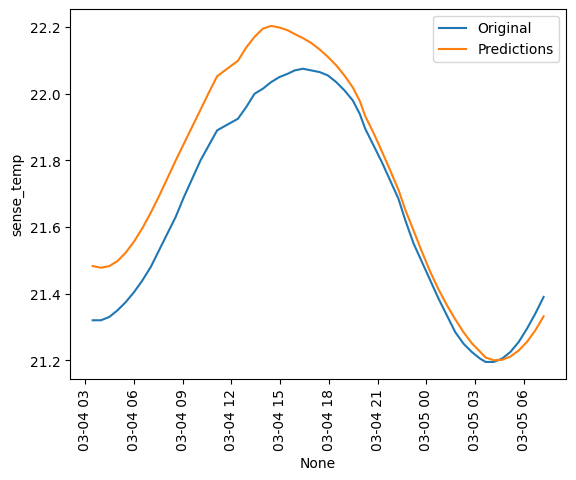

In [47]:
sns.lineplot(data = original, x = original.index, y = "sense_temp", label = "Original")
sns.lineplot(data = df_forecast, x = df_forecast.index, y = "sense_temp", label = "Predictions")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [48]:
display(original.head())
display(df_forecast.head())

,sense_temp
2024-03-04 03:27:07,21.320
2024-03-04 03:57:46,21.320
2024-03-04 04:28:24,21.330
2024-03-04 04:59:03,21.350
2024-03-04 05:29:42,21.375


,sense_temp
2024-03-04 03:27:07,21.482718
2024-03-04 03:57:46,21.477814
2024-03-04 04:28:24,21.482525
2024-03-04 04:59:03,21.498014
2024-03-04 05:29:42,21.523520


In [49]:
from sklearn.metrics import mean_squared_error
import cmath
mse = mean_squared_error(original["sense_temp"], df_forecast["sense_temp"])
rmse = cmath.sqrt(mse)
print("MSE = {}".format(mse, 2)) 
print("RMSE = {}".format(rmse, 2)) 

MSE = 0.011957088424694113
RMSE = (0.10934847243877764+0j)


On average predictions differ 0.13 degrees Cº from true value

In [ ]:
#save model
#model.save("models_temp/model13_21_01.h5")

### Trial

In [ ]:
from keras.models import load_model

df_trial = pd.read_csv("/home/fraia/Arduino/Predictive Model/data/trial_data.csv")

df_trial["timestamp"] = pd.to_datetime(df_trial["timestamp"])
df_trial = df_trial.set_index("timestamp")

drop_col = ["id", "pressure"]
df_trial = df_trial.drop(columns=drop_col)

model2 = load_model("/home/fraia/Arduino/Predictive Model/LSTM/models_temp/model13_21_01.h5")


In [ ]:
last_index = df_cl.index[-1]
df_trial = df_trial.loc[last_index:, ]

#Intervals of 30 min - undersampling
df_trial = df_trial[::6]

In [ ]:
df_trial

In [ ]:
# Create a Series with new values
add_wt = pd.Series([60, 70, 75, 80, 80, 90, 90])

# Replace values in the "water_temp" column with the values from add_wt
df_trial["water_temp"] = add_wt.values

In [ ]:
df_trial_con = df_trial.iloc[1:, ]
df_simul = pd.concat([df_cl, df_trial_con], axis=0)

df_simul = df_simul.drop(columns="pressure")

In [ ]:
from feature_selection import check_stationarity, scaling, feat_extraction

# Rolling window - smoothing data
# Detrending with diff
df_rolled2 = df_simul.rolling(window = 20).mean().dropna()
df_rolled2["water_temp_log"] = np.log(df_rolled2["water_temp"])
df_rolled2["st_wt"] = df_rolled2["sense_temp"] * df_rolled2["water_temp"]

df_diff2 = df_rolled2.diff().dropna()

# Feature Engineering
df_stationar2 = check_stationarity(df_diff2)
df_scaled2, scaler2 = scaling(df_stationar2)
X2, y2= feat_extraction(df_scaled2, target_col="sense_temp")

In [ ]:
df_scaled2 = df_scaled2.set_index("timestamp")

In [ ]:
# Final DF
final_col = ["open_temp__sum_values"]
final_df = pd.concat([y2, df_scaled2["st_wt"], X2[final_col]], axis=1)

In [ ]:
final_df.tail()

In [ ]:
# Initialize empty list to store past predictions
predictions = [1.577090]
real_predictions = []

n_future = 1  # Number of hours (12 = 1 hr) to predict
n_past = 5  # Number of past values for initial prediction

upper_bound = -8
lower_bound = -3
counter = 0

# Loop for iterative predictions
# As long as the counter is smaller than the length of the df from the lower bound onwards do:
while counter <= len(final_df.iloc[lower_bound+1:,]):  # Loop through each predicted value
    
    # Preparing df for predictions ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    hist_data = final_df.iloc[upper_bound+counter:lower_bound + counter] # Create a df containing all variables with historical values (we don't want the whole df so we slice a small part bounded by upper and lower bounds)
    hist_data_df = pd.DataFrame(hist_data) 
    actual_data = final_df.iloc[lower_bound + counter + 1, 1:] # Extract a row representing present values without including the target varaible "sense_temp"
    actual_data_df = pd.DataFrame(actual_data).T 

    prediction_value = predictions[-1] # Take the last value in predictions, which represents the "present" value for "sense_temp" 
    if np.ndim(prediction_value) > 1:  # Check if it's a multi-dimensional array
        prediction_value = prediction_value.flatten()[-1]
    predicted_temp = pd.DataFrame({"sense_temp": prediction_value}, index = actual_data_df.index) # Create a df containing the present value for "sense_temp", index is the same as the one from the actual_data_df ("present" values for the other variables)

    new_row = pd.concat([predicted_temp, actual_data_df], axis=1) # Create the row with present values, concatenate sense_temp with present values of other variables
    pred_df = pd.concat([hist_data_df, new_row]) # Append new row(present values) to df with historical data 
    print(pred_df)
    
    # Shape data into a 3D array for LSTM model----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    test_X2 = []

    for i in range(n_past, len(pred_df) - n_future + 1):
        test_X2.append(pred_df.iloc[i - n_past:i, :])
    test_X2 = np.array(test_X2)

    print("shape: {}".format(test_X2.shape))

    # Predictions
    forecast2 = model2.predict(test_X2)
    predictions.append(forecast2)  # Store the prediction

    # Transformation to real values (without scaling and difference)-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    forecast_copies2 = np.repeat(forecast2, df_diff2.shape[1], axis = -1)
    y_pred_future2 = scaler2.inverse_transform(forecast_copies2)[:, 0]

    #last real value of train set
    if len(real_predictions) == 0:
        diff_index = df_simul.index[-3]
        diff_value = df_rolled2["sense_temp"][diff_index]
    else:
        diff_value = real_predictions[-1]

    y_pred_real = y_pred_future2.cumsum() + diff_value

    # Results --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    real_predictions.append(y_pred_real)
    
    print("temperature: {0} at time {1}".format(y_pred_real, actual_data_df.index))
    counter += 1

print("test_x shape after predictions == {}".format(test_X2.shape))
print("temperature:")
[print(i, end=' ') for i in real_predictions] 

### Record Keeping:

#### Model: 13
- **Variables:** "sense_temp", "st_wt", "open_temp__sum_values"
- **Rolling:** rolling(window = 5).mean()
- **Lags:** 5
- **Hidden layers:** 1 with 64 neurons and 1 with 32
- **Activation Function:** RELU
- **Learning rate:** 0.001
- **RMSE:** 0.24

| Input | Output (Mean) | Output (Mean) | Output (Mean) |
|-------|---------------|---------------|---------------|
| [60, 70, 75, 80, 80, 90, 90] | 21.704067 | 21.77113 | 21.83511 |
| [50, 50, 50, 50, 50, 60, 57] | 21.703907 | 21.771793 | 21.839293 |
| [35, 35, 35, 36, 36, 37, 40] | 21.703793 | 21.771206 | 21.835903 |
| [30, 31, 32, 33, 35, 35, 35] | 21.703646 | 21.770754 | 21.834362 |
| [34, 34, 35, 35, 35, 35, 36] | 21.70359 | 21.770805 | 21.834938 |
| [30, 30, 30, 31, 32, 32, 32] | 21.703253 | 21.769571 | 21.83221 |
| [30, 29, 28, 26, 27, 25, 25] | 21.702013 | 21.767279 | 21.827528 |
| [30, 27, 26, 25, 23, 22, 22] | 21.701664 | 21.765833 | 21.824724 |
| [20, 20, 21, 22, 21, 20, 19] | 21.700176 | 21.762615 | 21.818823 |

#### Model: 12
- **Variables:** "sense_temp", "water_temp_log", "open_temp__sum_values", 'sense_hum__quantile__q_0.8'
- **Rolling:** rolling(window = 20).mean()
- **Lags:** 5
- **Hidden layers:** 1 with 64 neurons and 1 with 32
- **Activation Function:** RELU
- **Learning rate:** 0.001
- **RMSE:** 0.21

| Input | Output (Mean) | Output (Mean) | Output (Mean) |
|-------|---------------|---------------|---------------|
| [60, 70, 75, 80, 80, 90, 90] | 21.764786 | 21.936255 | 22.13393 |
| [50, 50, 50, 50, 50, 60, 57] | 21.733772 | 21.85097 | 21.995373 |
| [35, 35, 35, 36, 36, 37, 40] | 21.709055 | 21.785915 | 21.869068 |
| [30, 31, 32, 33, 35, 35, 35] | 21.703152 | 21.772224 | 21.845083 |
| [34, 34, 35, 35, 35, 35, 36] | 21.708054 | 21.783344 | 21.863754 |
| [30, 30, 30, 31, 32, 32, 32] | 21.70072 | 21.765863 | 21.833595 |
| [30, 29, 28, 26, 27, 25, 25] | 21.697824 | 21.758463 | 21.819193 |
| [30, 27, 26, 25, 23, 22, 22] | 21.69594 | 21.752842 | 21.808393 |
| [20, 20, 21, 22, 21, 20, 19] | 21.692213 | 21.744019 | 21.792473 |

#### Model: 11
- **Variables:** "sense_temp", "st_wt", "open_temp__sum_values", 'sense_hum__quantile__q_0.8'
- **Rolling:** rolling(window = 20).mean()
- **Lags:** 5
- **Hidden layers:** 1 with 64 neurons and 1 with 32
- **Activation Function:** RELU
- **Learning rate:** 0.001
- **RMSE:** 0.10

| Input | Output (Mean) | Output (Mean) | Output (Mean) |
|-------|---------------|---------------|---------------|
| [60, 70, 75, 80, 80, 90, 90] | 21.77357 | 21.966558 | 22.20211 |
| [50, 50, 50, 50, 50, 60, 57] | 21.74708 | 21.883806 | 22.054888 |
| [35, 35, 35, 36, 36, 37, 40] | 21.720036 | 21.809212 | 21.906208 |
| [30, 31, 32, 33, 35, 35, 35] | 21.71269 | 21.791813 | 21.87478 |
| [34, 34, 35, 35, 35, 35, 36] | 21.718748 | 21.80575 | 21.898588 |
| [30, 30, 30, 31, 32, 32, 32] | 21.709723 | 21.78401 | 21.859812 |
| [30, 29, 28, 26, 27, 25, 25] | 21.705576 | 21.773424 | 21.839891 |
| [30, 27, 26, 25, 23, 22, 22] | 21.70246 | 21.765099 | 21.825186 |
| [20, 20, 21, 22, 21, 20, 19] | 21.697395 | 21.752861 | 21.803223 |
| [20, 19, 18, 17, 16, 16, 16] | 21.693548 | 21.744003 | 21.790922 |                     

#### Model: 10
- **Variables:** "sense_temp", "water_temp", "open_temp__sum_values", 'sense_hum__quantile__q_0.8'
- **Rolling:** rolling(window = 20).mean()
- **Lags:** 5
- **Hidden layers:** 1 with 64 neurons and 1 with 32
- **Activation Function:** RELU
- **Learning rate:** 0.001
- **RMSE:** 0.15

| Input | Output (Mean) | Output (Mean) | Output (Mean) |
|-------|---------------|---------------|---------------|
| [60, 70, 75, 80, 80, 90, 90] | 21.784746 | 21.944775 | 22.073172 |
| [50, 50, 50, 50, 50, 60, 57] | 21.746998 | 21.869518 | 21.997324 |
| [35, 35, 35, 36, 36, 37, 40] | 21.714718 | 21.79595 | 21.881897 |
| [30, 31, 32, 33, 35, 35, 35] | 21.708353 | 21.781685 | 21.857882 |
| [34, 34, 35, 35, 35, 35, 36] | 21.713501 | 21.792883 | 21.87607 |
| [30, 30, 30, 31, 32, 32, 32] | 21.705763 | 21.774834 | 21.844976 |
| [30, 29, 28, 26, 27, 25, 25] | 21.701904 | 21.764572 | 21.82566 |
| [30, 27, 26, 25, 23, 22, 22] | 21.699467 | 21.757494 | 21.812931 |
| [20, 20, 21, 22, 21, 20, 19] | 21.693586 | 21.745195 | 21.793629 |
